In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models, transforms
from torchvision import transforms, utils
from torchvision import datasets

from torchsummary import summary


from mm_patch.data import PatchesDataset
import mm_patch.transforms
from mm_patch.utils import image_from_index



In [2]:
# Auxiliary function for dataloader
def read_image_png(file_name):
    image = np.array(imageio.imread(file_name)).astype(np.int32)
    return image

___
## If we want to standarize the input:

**TODO: needs to work also for dtype = int. I believe the problem is with transforms.Normalize()**

In [ ]:
# Load all images to calculate mean and std
# patches_raw = datasets.ImageFolder('/scratch/fbarone/patches_256_CRO_23072019',  transform = transforms.ToTensor(), target_transform=None, loader=read_image_png)
patches_raw = datasets.ImageFolder('/scratch/fbarone/test_256',  transform = transforms.ToTensor(), target_transform=None, loader=read_image_png)

In [ ]:
# Auxiliary function to calculate mean and std using pytorch dataloader
def online_mean_and_std(loader):
    """Compute the mean and std for all pixels in an image.
    It does not require to have all the dataset loaded in RAM 
    as it calculates it one batch at a time.

        Var[x] = E[X^2] - E^2[X]
        
    ref: https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/8
    """
    cnt = 0
    # Is there a better way of checking the # of channels?
    channels = next(iter(loader))[0].shape[1]
    if channels not in [1,2,3]:
        raise ValueError("input channels must be between 1 and 3.")
    
    
    fst_moment = torch.empty(channels)
    snd_moment = torch.empty(channels)

    for img_batch,_ in loader:

        b, c, h, w = img_batch.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(img_batch.float(), dim=[0, 2, 3])
        sum_of_square = torch.sum(img_batch.float() ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [ ]:
# First I create a dataloader to calculate mean and std of the pixels.
# For the latter I will use `online_mean_and_std(loader)`
# patches = PatchesDataset(data_path='./patches.pkl', transform = mm_patch.transforms.ToTensor())
# there is no race condition for num_workers != 0. It just use workers to load the images in ram.
loader_raw = DataLoader(patches_raw, batch_size=20, shuffle=False, num_workers=10)
mean_px, std_px = online_mean_and_std(loader_raw)
print(mean_px.dtype,std_px.dtype)
print(mean_px, std_px)

______

## Dataset and Dataloader

In [3]:
# Transformations to be compatible with Densenet-121 from NYU paper.
# Note I am using mean and std as recommended in Pytorch. Maybe calculating the dataset statistics is better.
composed = transforms.Compose([ 
#                                 mm_patch.transforms.ToImage(),
                                transforms.ToTensor(),
                                mm_patch.transforms.Scale()
#                                 mm_patch.transforms.GrayToRGB(),
#                                 transforms.Normalize(mean=[18820.3496], std=[8547.6963])
                            ])

In [4]:
patches = datasets.ImageFolder('/scratch/fbarone/patches_256_CRO_23072019',  transform = composed, target_transform=None, loader=read_image_png)
# patches = datasets.ImageFolder('/scratch/fbarone/test_256',  transform = composed, target_transform=None, loader=read_image_png)

In [5]:
len(patches)

73400

In [6]:
loader = DataLoader(patches, batch_size=20, shuffle=False, num_workers=10)
mean_px, std_px = online_mean_and_std(loader)
print(mean_px, std_px)

NameError: name 'online_mean_and_std' is not defined

In [7]:
# # Set dataset
# patches = PatchesDataset(data_path='./patches_256x256.pkl', transform = composed)

# Dataloader parameters
batch_size = 80
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(patches)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# this train loader is to have random access
# loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
#                                             num_workers=10)
train_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=10)
validation_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=10)

### Model definition

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Basic_CAE(nn.Module):
    def __init__(self):
        super(Basic_CAE, self).__init__()
        
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.Conv2d(128, 128, 3, padding = 1)
        self.t_conv2 = nn.Conv2d(128, 64, 3, padding = 1)
        self.t_conv3 = nn.Conv2d(64, 1, 3, padding = 1)
        self.upsampling = nn.modules.upsampling.Upsample(scale_factor=2, mode='nearest')
#         self.t_conv3 = nn.ConvTranspose2d(4, 2, 2, stride=2)
#         self.t_conv4 = nn.ConvTranspose2d(2, 1, 2, stride=2)
#         self.t_conv4 = nn.ConvTranspose2d(2, 1, 2, stride=2)
        
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
#         self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)

        
    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))


       
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = self.upsampling(x)
        x = F.relu(self.t_conv2(x))
        x = self.upsampling(x)
        x = torch.sigmoid(self.t_conv3(x))
                
        return x

In [11]:
# initialize the NN
model = Basic_CAE()
# print(model)

In [12]:
# for param in model.parameters():
#     print(param)

In [13]:
# check for nvidia library
torch.has_cudnn

True

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

model = model.to(device)
# F: sets model in evaluation mode. It has an effect in certain modules: e.g. Dropout or BatchNorm Layers
# model.eval()

In [15]:
# from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
summary(model, input_size=(1, 256, 256), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
            Conv2d-6          [-1, 128, 64, 64]         147,584
          Upsample-7        [-1, 128, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          73,792
          Upsample-9         [-1, 64, 256, 256]               0
           Conv2d-10          [-1, 1, 256, 256]             577
Total params: 314,625
Trainable params: 314,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 94.50
Params size (MB): 1.20
Estimated 

In [16]:
# # Example of using Sequential with OrderedDict
# model = nn.Sequential(OrderedDict([
#           ('conv1', nn.Conv2d(1,20,5)),
#           ('relu1', nn.ReLU()),
#           ('conv2', nn.Conv2d(20,64,5)),
#           ('relu2', nn.ReLU())
#         ]))


___

## Model Training

In [19]:
# loss function
criterion = nn.MSELoss()

# loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters())

In [20]:
# if steps % print_every == 0:
#             model.eval()
#             with torch.no_grad():
#                 test_loss, accuracy = validation(model, testloader, criterion)

#             print("Epoch: {}/{}.. ".format(e+1, epochs),
#                   "Training Loss: {:.3f}.. ".format(running_loss/print_every),
#                   "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
#                   "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

#             running_loss = 0

In [22]:
# number of epochs to train the model
n_epochs = 30
print_freq = batch_size // 2

for epoch in range(0, n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for i_batch,data in enumerate(train_loader):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data[0].to(device), data[1]
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
#         print(images.size(0))
            
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    

Epoch: 0 	Training Loss: 0.001824
Epoch: 1 	Training Loss: 0.001443


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/u/f/fbarone/anaconda3/envs/phang/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/u/

KeyboardInterrupt: 

In [ ]:
len(train_loader)*80 + 73400*0.2

In [ ]:
train_loader.batch_size

### Save model

In [ ]:
epoch

In [ ]:
# ref: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/scratch/fbarone/cae_models/Basic_CAE.pt'

# # straight forward way
# # torch.save(model.state_dict(), PATH)

# # save checkpoint
# # Note that the checkpoint includes the number of epoch, the optimizer state. The dict can be extended.
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, PATH)


### Load model

In [ ]:
# PATH = '/scratch/fbarone/cae_models/Basic_CAE.pt'

# straight forward way
# model.load_state_dict(torch.load(PATH))

# load checkpoint
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()



___
## Results

10
torch.Size([1, 256, 256])


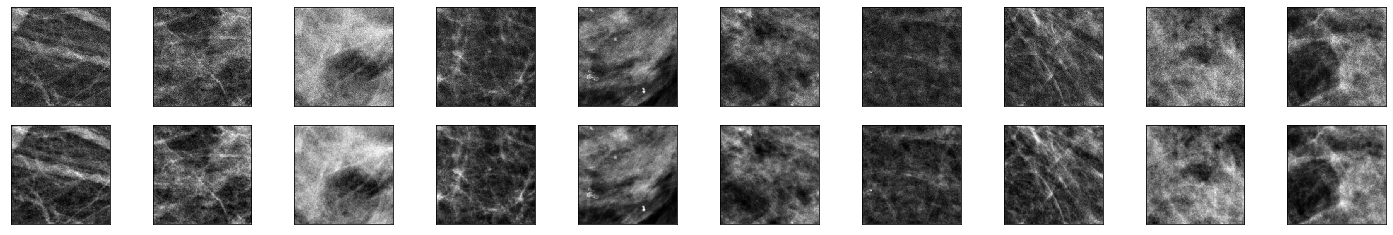

In [23]:
# obtain one batch of test images
num_patches = 10
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images[:num_patches]
len(images)
# get sample outputs
output = model(images.to(device=device))
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
print(len(output))
print(output[0].shape)
output = output.view(num_patches, 1, 256, 256)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)